# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [3]:
def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [4]:
class Config():
    training_dir = "augmented/train/"
    testing_dir = "augmented/test/"
    train_batch_size = 64
    train_number_epochs = 1000

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/home/kbstudios/anaconda3/envs/python35/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
0 indiciates dissimilar, and 1 indicates similar.

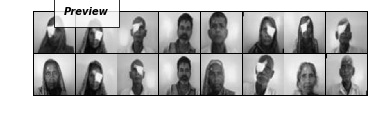

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]]


Process Process-6:
Process Process-4:
Process Process-3:
Process Process-1:
Process Process-5:
Process Process-2:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, i

In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated), "Preview")
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [11]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [12]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [13]:
counter = []
loss_history = [] 
iteration_number= 0

In [16]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

Epoch number 0
 Current loss 0.5586793422698975

Epoch number 0
 Current loss 0.3499588072299957

Epoch number 0
 Current loss 0.4201739430427551

Epoch number 0
 Current loss 0.6168703436851501

Epoch number 0
 Current loss 0.36080485582351685

Epoch number 0
 Current loss 0.5910113453865051

Epoch number 0
 Current loss 0.6434010863304138

Epoch number 0
 Current loss 0.46566513180732727

Epoch number 0
 Current loss 0.44400957226753235

Epoch number 0
 Current loss 0.45146673917770386

Epoch number 0
 Current loss 0.4836384356021881

Epoch number 0
 Current loss 0.5001558065414429

Epoch number 0
 Current loss 0.5081504583358765

Epoch number 1
 Current loss 0.44506534934043884

Epoch number 1
 Current loss 0.37375006079673767

Epoch number 1
 Current loss 0.610833466053009

Epoch number 1
 Current loss 0.36610838770866394

Epoch number 1
 Current loss 0.4009700119495392

Epoch number 1
 Current loss 0.5191879868507385

Epoch number 1
 Current loss 0.4332645833492279

Epoch number 1

Epoch number 12
 Current loss 0.32789793610572815

Epoch number 12
 Current loss 0.4818125069141388

Epoch number 12
 Current loss 0.2544567883014679

Epoch number 13
 Current loss 0.4535328447818756

Epoch number 13
 Current loss 0.5208748579025269

Epoch number 13
 Current loss 0.4682259261608124

Epoch number 13
 Current loss 0.48187363147735596

Epoch number 13
 Current loss 0.46964725852012634

Epoch number 13
 Current loss 0.4092502295970917

Epoch number 13
 Current loss 0.515505313873291

Epoch number 13
 Current loss 0.3047691583633423

Epoch number 13
 Current loss 0.47400328516960144

Epoch number 13
 Current loss 0.4082687497138977

Epoch number 13
 Current loss 0.3488105833530426

Epoch number 13
 Current loss 0.36505764722824097

Epoch number 13
 Current loss 0.5666303634643555

Epoch number 14
 Current loss 0.584679126739502

Epoch number 14
 Current loss 0.3347882032394409

Epoch number 14
 Current loss 0.40728819370269775

Epoch number 14
 Current loss 0.42314788699150

Epoch number 25
 Current loss 0.37113338708877563

Epoch number 25
 Current loss 0.3311695158481598

Epoch number 25
 Current loss 0.4038749933242798

Epoch number 25
 Current loss 0.285427987575531

Epoch number 25
 Current loss 0.3008735775947571

Epoch number 25
 Current loss 0.3446047604084015

Epoch number 25
 Current loss 0.3757320046424866

Epoch number 25
 Current loss 0.406035840511322

Epoch number 25
 Current loss 0.5181606411933899

Epoch number 26
 Current loss 0.4991655647754669

Epoch number 26
 Current loss 0.4399503469467163

Epoch number 26
 Current loss 0.4443177878856659

Epoch number 26
 Current loss 0.38692355155944824

Epoch number 26
 Current loss 0.4285339415073395

Epoch number 26
 Current loss 0.3069307208061218

Epoch number 26
 Current loss 0.4131266176700592

Epoch number 26
 Current loss 0.32380470633506775

Epoch number 26
 Current loss 0.45231175422668457

Epoch number 26
 Current loss 0.4053894579410553

Epoch number 26
 Current loss 0.4634877443313598

Epoch number 37
 Current loss 0.39137333631515503

Epoch number 37
 Current loss 0.4158327877521515

Epoch number 38
 Current loss 0.406754732131958

Epoch number 38
 Current loss 0.38608866930007935

Epoch number 38
 Current loss 0.32991132140159607

Epoch number 38
 Current loss 0.2920321226119995

Epoch number 38
 Current loss 0.32292965054512024

Epoch number 38
 Current loss 0.43227675557136536

Epoch number 38
 Current loss 0.44327861070632935

Epoch number 38
 Current loss 0.37563562393188477

Epoch number 38
 Current loss 0.33739352226257324

Epoch number 38
 Current loss 0.4580973982810974

Epoch number 38
 Current loss 0.45892754197120667

Epoch number 38
 Current loss 0.3132537007331848

Epoch number 38
 Current loss 0.3890027105808258

Epoch number 39
 Current loss 0.512576162815094

Epoch number 39
 Current loss 0.3782849609851837

Epoch number 39
 Current loss 0.47644564509391785

Epoch number 39
 Current loss 0.4281858503818512

Epoch number 39
 Current loss 0.3005728721

Epoch number 50
 Current loss 0.33784595131874084

Epoch number 50
 Current loss 0.26545798778533936

Epoch number 50
 Current loss 0.28770753741264343

Epoch number 50
 Current loss 0.26209425926208496

Epoch number 50
 Current loss 0.36421066522598267

Epoch number 50
 Current loss 0.4220823645591736

Epoch number 50
 Current loss 0.331964910030365

Epoch number 50
 Current loss 0.3365859091281891

Epoch number 51
 Current loss 0.33162200450897217

Epoch number 51
 Current loss 0.34870386123657227

Epoch number 51
 Current loss 0.38878193497657776

Epoch number 51
 Current loss 0.46555688977241516

Epoch number 51
 Current loss 0.3105146288871765

Epoch number 51
 Current loss 0.35090696811676025

Epoch number 51
 Current loss 0.3833640515804291

Epoch number 51
 Current loss 0.28433501720428467

Epoch number 51
 Current loss 0.3696101903915405

Epoch number 51
 Current loss 0.3169909715652466

Epoch number 51
 Current loss 0.4547189474105835

Epoch number 51
 Current loss 0.46283933

Epoch number 62
 Current loss 0.356745183467865

Epoch number 63
 Current loss 0.36742156744003296

Epoch number 63
 Current loss 0.3287321925163269

Epoch number 63
 Current loss 0.3515969216823578

Epoch number 63
 Current loss 0.3198273181915283

Epoch number 63
 Current loss 0.4218982458114624

Epoch number 63
 Current loss 0.3574404716491699

Epoch number 63
 Current loss 0.25947701930999756

Epoch number 63
 Current loss 0.29948189854621887

Epoch number 63
 Current loss 0.4182063341140747

Epoch number 63
 Current loss 0.4063614010810852

Epoch number 63
 Current loss 0.30176976323127747

Epoch number 63
 Current loss 0.35926008224487305

Epoch number 63
 Current loss 0.28760308027267456

Epoch number 64
 Current loss 0.3809361159801483

Epoch number 64
 Current loss 0.3629964292049408

Epoch number 64
 Current loss 0.2345000058412552

Epoch number 64
 Current loss 0.20836715400218964

Epoch number 64
 Current loss 0.33850717544555664

Epoch number 64
 Current loss 0.32175529003

Epoch number 75
 Current loss 0.3303775191307068

Epoch number 75
 Current loss 0.32755929231643677

Epoch number 75
 Current loss 0.17270402610301971

Epoch number 75
 Current loss 0.2952648997306824

Epoch number 75
 Current loss 0.36014100909233093

Epoch number 75
 Current loss 0.2699853181838989

Epoch number 75
 Current loss 0.4036320447921753

Epoch number 76
 Current loss 0.24974115192890167

Epoch number 76
 Current loss 0.34051284193992615

Epoch number 76
 Current loss 0.3276634216308594

Epoch number 76
 Current loss 0.39277341961860657

Epoch number 76
 Current loss 0.25853416323661804

Epoch number 76
 Current loss 0.353311687707901

Epoch number 76
 Current loss 0.30228936672210693

Epoch number 76
 Current loss 0.2442411184310913

Epoch number 76
 Current loss 0.3198261260986328

Epoch number 76
 Current loss 0.2392958551645279

Epoch number 76
 Current loss 0.37825527787208557

Epoch number 76
 Current loss 0.3580039143562317

Epoch number 76
 Current loss 0.3242096900

Epoch number 88
 Current loss 0.2773272693157196

Epoch number 88
 Current loss 0.5691400170326233

Epoch number 88
 Current loss 0.36161908507347107

Epoch number 88
 Current loss 0.3916834592819214

Epoch number 88
 Current loss 0.19449838995933533

Epoch number 88
 Current loss 0.2442026436328888

Epoch number 88
 Current loss 0.42954015731811523

Epoch number 88
 Current loss 0.3000192642211914

Epoch number 88
 Current loss 0.2182401567697525

Epoch number 88
 Current loss 0.24744737148284912

Epoch number 88
 Current loss 0.25921955704689026

Epoch number 88
 Current loss 0.17466315627098083

Epoch number 88
 Current loss 0.20887182652950287

Epoch number 89
 Current loss 0.28227367997169495

Epoch number 89
 Current loss 0.3493399918079376

Epoch number 89
 Current loss 0.22700023651123047

Epoch number 89
 Current loss 0.30195942521095276

Epoch number 89
 Current loss 0.403070867061615

Epoch number 89
 Current loss 0.3926106095314026

Epoch number 89
 Current loss 0.284244716

Epoch number 100
 Current loss 0.25369125604629517

Epoch number 100
 Current loss 0.4011159837245941

Epoch number 100
 Current loss 0.2995277941226959

Epoch number 100
 Current loss 0.3949618339538574

Epoch number 100
 Current loss 0.3464299440383911

Epoch number 100
 Current loss 0.24918785691261292

Epoch number 101
 Current loss 0.20778632164001465

Epoch number 101
 Current loss 0.38906919956207275

Epoch number 101
 Current loss 0.27023783326148987

Epoch number 101
 Current loss 0.22081461548805237

Epoch number 101
 Current loss 0.3040589988231659

Epoch number 101
 Current loss 0.28271523118019104

Epoch number 101
 Current loss 0.48965534567832947

Epoch number 101
 Current loss 0.30429017543792725

Epoch number 101
 Current loss 0.4519890248775482

Epoch number 101
 Current loss 0.2640896141529083

Epoch number 101
 Current loss 0.26096296310424805

Epoch number 101
 Current loss 0.3248078525066376

Epoch number 101
 Current loss 0.4023187756538391

Epoch number 102
 Cur

Epoch number 112
 Current loss 0.2204812616109848

Epoch number 112
 Current loss 0.34873726963996887

Epoch number 113
 Current loss 0.2935357689857483

Epoch number 113
 Current loss 0.2833958864212036

Epoch number 113
 Current loss 0.3767155706882477

Epoch number 113
 Current loss 0.3938342034816742

Epoch number 113
 Current loss 0.25807109475135803

Epoch number 113
 Current loss 0.19314470887184143

Epoch number 113
 Current loss 0.20920051634311676

Epoch number 113
 Current loss 0.1942826211452484

Epoch number 113
 Current loss 0.30387556552886963

Epoch number 113
 Current loss 0.17543110251426697

Epoch number 113
 Current loss 0.27099356055259705

Epoch number 113
 Current loss 0.2344495803117752

Epoch number 113
 Current loss 0.23754826188087463

Epoch number 114
 Current loss 0.22240278124809265

Epoch number 114
 Current loss 0.28068846464157104

Epoch number 114
 Current loss 0.19018183648586273

Epoch number 114
 Current loss 0.23339244723320007

Epoch number 114
 C

Epoch number 125
 Current loss 0.33515334129333496

Epoch number 125
 Current loss 0.32112106680870056

Epoch number 125
 Current loss 0.21957655251026154

Epoch number 125
 Current loss 0.21119020879268646

Epoch number 125
 Current loss 0.4052795171737671

Epoch number 125
 Current loss 0.3902137577533722

Epoch number 125
 Current loss 0.27953478693962097

Epoch number 125
 Current loss 0.43237999081611633

Epoch number 125
 Current loss 0.2527969181537628

Epoch number 125
 Current loss 0.3149312436580658

Epoch number 125
 Current loss 0.33848854899406433

Epoch number 126
 Current loss 0.31002184748649597

Epoch number 126
 Current loss 0.2638624608516693

Epoch number 126
 Current loss 0.23012837767601013

Epoch number 126
 Current loss 0.23226089775562286

Epoch number 126
 Current loss 0.29136404395103455

Epoch number 126
 Current loss 0.21077090501785278

Epoch number 126
 Current loss 0.27813148498535156

Epoch number 126
 Current loss 0.29182419180870056

Epoch number 126


Epoch number 137
 Current loss 0.22086450457572937

Epoch number 137
 Current loss 0.29022127389907837

Epoch number 137
 Current loss 0.18493999540805817

Epoch number 137
 Current loss 0.29441267251968384

Epoch number 137
 Current loss 0.33332952857017517

Epoch number 137
 Current loss 0.1926763653755188

Epoch number 137
 Current loss 0.28862303495407104

Epoch number 137
 Current loss 0.1793694645166397

Epoch number 138
 Current loss 0.22657708823680878

Epoch number 138
 Current loss 0.3218819499015808

Epoch number 138
 Current loss 0.35858675837516785

Epoch number 138
 Current loss 0.3101632595062256

Epoch number 138
 Current loss 0.21756993234157562

Epoch number 138
 Current loss 0.2713128328323364

Epoch number 138
 Current loss 0.2519630491733551

Epoch number 138
 Current loss 0.24196210503578186

Epoch number 138
 Current loss 0.3335544168949127

Epoch number 138
 Current loss 0.4017174541950226

Epoch number 138
 Current loss 0.33728480339050293

Epoch number 138
 Cu

Epoch number 149
 Current loss 0.26806503534317017

Epoch number 149
 Current loss 0.34177833795547485

Epoch number 149
 Current loss 0.41201692819595337

Epoch number 149
 Current loss 0.23900094628334045

Epoch number 150
 Current loss 0.34265103936195374

Epoch number 150
 Current loss 0.3464159071445465

Epoch number 150
 Current loss 0.36603349447250366

Epoch number 150
 Current loss 0.2640315890312195

Epoch number 150
 Current loss 0.16344909369945526

Epoch number 150
 Current loss 0.16945485770702362

Epoch number 150
 Current loss 0.3990645408630371

Epoch number 150
 Current loss 0.31786730885505676

Epoch number 150
 Current loss 0.1819237470626831

Epoch number 150
 Current loss 0.2057124525308609

Epoch number 150
 Current loss 0.28027740120887756

Epoch number 150
 Current loss 0.2755564749240875

Epoch number 150
 Current loss 0.2983033061027527

Epoch number 151
 Current loss 0.33618712425231934

Epoch number 151
 Current loss 0.28378093242645264

Epoch number 151
 C

Epoch number 161
 Current loss 0.18661539256572723

Epoch number 162
 Current loss 0.3998607397079468

Epoch number 162
 Current loss 0.20427031815052032

Epoch number 162
 Current loss 0.2751462757587433

Epoch number 162
 Current loss 0.3350970447063446

Epoch number 162
 Current loss 0.29220348596572876

Epoch number 162
 Current loss 0.3068233132362366

Epoch number 162
 Current loss 0.40717485547065735

Epoch number 162
 Current loss 0.25511470437049866

Epoch number 162
 Current loss 0.3203175365924835

Epoch number 162
 Current loss 0.19941817224025726

Epoch number 162
 Current loss 0.39267414808273315

Epoch number 162
 Current loss 0.24732042849063873

Epoch number 162
 Current loss 0.3013854920864105

Epoch number 163
 Current loss 0.2456427365541458

Epoch number 163
 Current loss 0.30653539299964905

Epoch number 163
 Current loss 0.33051010966300964

Epoch number 163
 Current loss 0.354800283908844

Epoch number 163
 Current loss 0.3686665892601013

Epoch number 163
 Curr

Epoch number 174
 Current loss 0.30228930711746216

Epoch number 174
 Current loss 0.3198171854019165

Epoch number 174
 Current loss 0.24098749458789825

Epoch number 174
 Current loss 0.16039405763149261

Epoch number 174
 Current loss 0.23038624227046967

Epoch number 174
 Current loss 0.42716845870018005

Epoch number 174
 Current loss 0.26514941453933716

Epoch number 174
 Current loss 0.178216353058815

Epoch number 174
 Current loss 0.21024078130722046

Epoch number 174
 Current loss 0.32415804266929626

Epoch number 175
 Current loss 0.35187989473342896

Epoch number 175
 Current loss 0.16565458476543427

Epoch number 175
 Current loss 0.18385626375675201

Epoch number 175
 Current loss 0.21833333373069763

Epoch number 175
 Current loss 0.24367521703243256

Epoch number 175
 Current loss 0.23015443980693817

Epoch number 175
 Current loss 0.19597934186458588

Epoch number 175
 Current loss 0.15875846147537231

Epoch number 175
 Current loss 0.2493254542350769

Epoch number 175

Process Process-1964:
Process Process-1962:
Process Process-1961:
Process Process-1966:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-1965:
Process Process-1963:
Process Process-1959:
Process Process-1960:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/kbstudios/anaconda3/envs/python35/lib/python3.5/multiprocessing/process.py", line 252, in _b

KeyboardInterrupt: 

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

/home/kbstudios/anaconda3/envs/python35/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


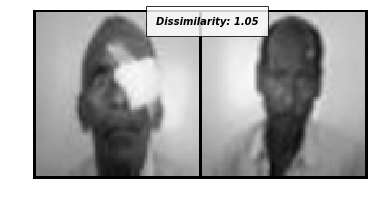

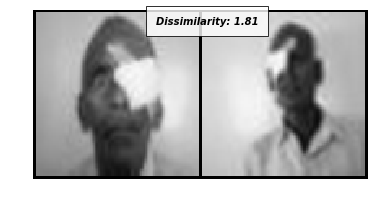

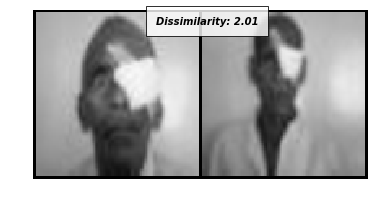

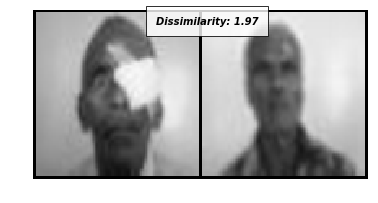

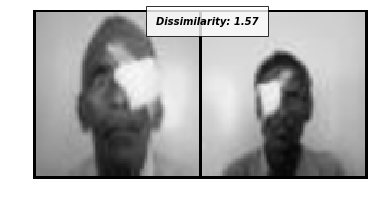

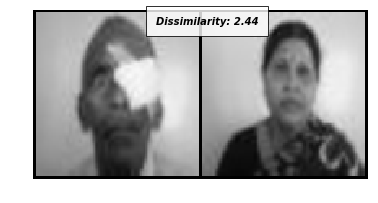

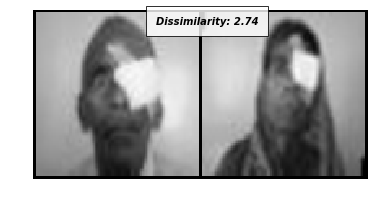

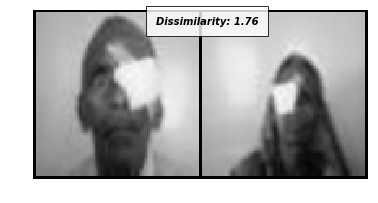

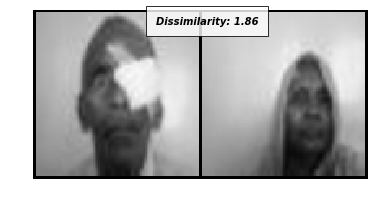

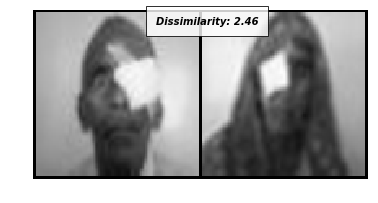

In [20]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))

